In [1]:
import pickle
import numpy as np
import  matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture
import cartopy.crs as ccrs
import colorcet as cc
import colormaps as clm
import matplotlib as mpl
from matplotlib.colors import Normalize

In [2]:
monsoon_coarse_path = "/docker/mnt/d/research/D2/cnn3/train_val/continuous/predictors_coarse_std_Apr_msot-pr_5x5_coarse_std_MJJASO_monsoon.pickle"
result_path = '/docker/mnt/d/research/D2/cnn3/result/continuous/monsoon/5x5/predictors_coarse_std_Apr_msot-pr_5x5_coarse_std_MJJASO_monsoon' \
              '/epoch100_batch256_seed1.npy'

with open(monsoon_coarse_path, 'rb') as f:
    data = pickle.load(f)
y_train, y_val  = data['y_train'], data['y_val']
pred = np.squeeze(np.load(result_path))

print(y_train.shape, y_val.shape, pred.shape)

(5930, 252) (1000, 252) (252, 1000)


In [3]:
def GMM(data):
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.reshape(-1, 1))
    estimated_group = gmm.predict(data.reshape(-1, 1))
    return gmm

def separate(pred, y):
    rmse_flat = []
    for sam in range(len(y)):
        value = pred[:, sam]
        label = y[sam, :]
        rmse = np.sqrt(np.mean((value - label)**2))
        rmse_flat.append(rmse)
        
    rmse_flat = np.array(rmse_flat)
    gmm = GMM(rmse_flat)
    criteria = np.mean([gmm.means_[0, -1],
                        gmm.means_[1, -1]])
    
    true_index, false_index = [], []
    for sam in range(len(y)):
        if rmse_flat[sam] <= criteria:
            true_index.append(sam)
        else:
            false_index.append(sam)
        
    true_pred = pred[:, true_index]
    true_y = y[true_index, :]
    false_pred = pred[:, false_index]
    false_y = y[false_index, :]
    print(f"true_pred: {true_pred.shape}, true_y: {true_y.shape}, false_pred: {false_pred.shape}, false_y: {false_y.shape}")
    
    return true_pred, true_y, false_pred, false_y

In [4]:
true_pred, true_y, false_pred, false_y = separate(pred, y_val)

true_pred: (252, 851), true_y: (851, 252), false_pred: (252, 149), false_y: (149, 252)


In [5]:
def show_prcp(image, vmin=-1, vmax=1):
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    cm = plt.cm.get_cmap('BrBG')
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     norm=Normalize(vmin=vmin, vmax=vmax),
                     cmap=cm,
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

def correlationcheck(data):
    grid_point = 1
    grid_comp = 252
    for i in range(grid_point):
        corr = []
        point = data[:, i]
        for j in range(grid_comp):
            comp = data[:, j]
            rr = np.corrcoef(point, comp)
            score = np.round(rr[0,1], 2)
            corr.append(score)
        corr = np.reshape(corr, (14, 18))
        show_prcp(corr, vmin=0, vmax=1.0)

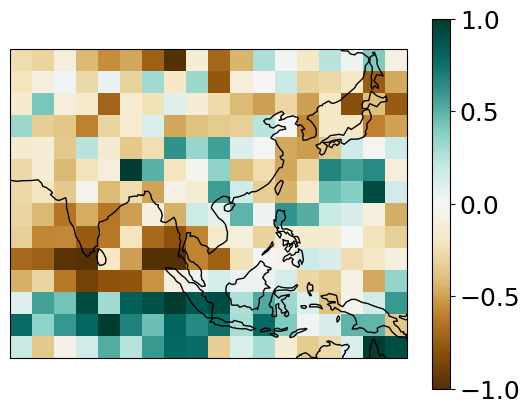

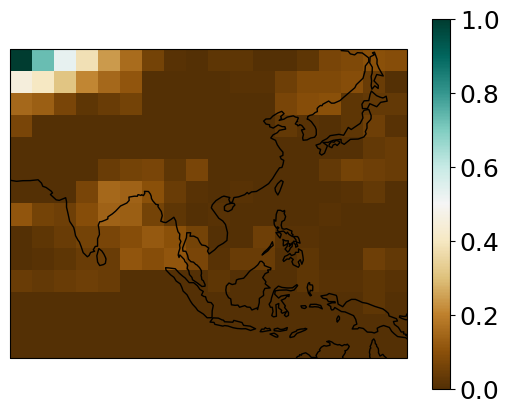

In [6]:
sand = true_pred[:, 0].reshape(14, 18)
sandbox = true_pred.T
show_prcp(sand)
correlationcheck(sandbox)

In [7]:
def make_mask(index_point, sample, threshold, sample_num):
    threshold = threshold # correlation
    
    point_num = index_point
    comp_num = 252
    
    sample_num = sample_num
    x_length = 18
    y_length = 14
    
    sample = sample.reshape(sample_num, y_length, x_length)
    sample = sample.reshape(sample_num, y_length*x_length)
    
    point = sample[:, index_point]

    corr = []
    for index_comp in range(comp_num):
        comp = sample[:, index_comp]
        rr = np.corrcoef(point, comp)
        score = np.round(rr[0, 1], 2)
        corr.append(score)

    corr = np.array(corr)
    mask = corr >= threshold
    return mask

def correlation_clustering(sample, initial_index=0, threshold=0.6, sample_num=1000):
    """
    sample.shape = 165, 14, 18
    165サンプルをつかって2グリッド(point, comp)の相関を調べる
    
    x_index = [0...17]
    y_index = [0...13]
    """
    x_length = 18
    y_length = 14
    
    ###################################### storing cluster coordinates ##################
    # initial criteria point
    index_point = initial_index 
    
    # initialization
    clst_coor = []
    clst_coor.append(index_point)
    done_lst = []
    
    while all(np.sort(done_lst) != np.sort(clst_coor)):
        for index_point in clst_coor:
            if index_point not in done_lst:
                mask = make_mask(index_point, sample, threshold, sample_num)

                # coordinate transformation
                x_index = index_point % x_length
                y_index = index_point // x_length

                # left
                if x_index != 0:
                    temp_x = x_index - 1
                    flat_index = x_length*y_index + temp_x
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: left")

               # right
                if x_index != (x_length - 1):
                    temp_x = x_index + 1
                    flat_index = x_length*y_index + temp_x
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: right")

                # up
                elif y_index != 0:
                    temp_y = y_index - 1
                    flat_index = x_length*temp_y + x_index
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: up")

                # down
                if y_index != (y_length - 1):
                    temp_y = y_index + 1
                    flat_index = x_length*temp_y + x_index
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: down")

                done_lst.append(index_point)
            else:
                print(f"index_point {index_point} is already in done_lst")
        
    return clst_coor

def reduce_cluster(sorted_cluster, cluster_num=3):
    """
    cluster_num: number of grids in one cluster
    """
    # unique selection
    unique_cluster = []
    seen_rows = set()

    for row in sorted_cluster:
        sorted_row = np.sort(row)
        row_tuple = tuple(sorted_row)
        if row_tuple not in seen_rows:
            unique_cluster.append(sorted_row)
            seen_rows.add(row_tuple)
            #print(sorted_row)

    #print(f"number of cluster {len(unique_cluster)}")
    
    # reduce by cluster_num
    reduced_cluster = []
    for i in range(len(unique_cluster)):
        if len(unique_cluster[i]) >= cluster_num:
             reduced_cluster.append(unique_cluster[i])
                
    # overlapped grid
    overlapped = []
    for list_a in reduced_cluster:
        candidate = []
        candidate_len = []
        for list_b in reduced_cluster:
            if any(item in list_a for item in list_b):
                candidate.append(list_b)
                candidate_len.append(len(list_b))
        arr = np.array(candidate_len)
        index = np.argmax(arr)
        overlapped.append(candidate[index])
    
    # unique selection
    unique_cluster = []
    seen_rows = set()

    for row in overlapped:
        sorted_row = np.sort(row)
        row_tuple = tuple(sorted_row)
        if row_tuple not in seen_rows:
            unique_cluster.append(sorted_row)
            seen_rows.add(row_tuple)
        
    return unique_cluster

def show_cluster(cluster_list):
    x_length = 18
    y_length = 14
    mask_image = np.zeros((y_length*x_length))
    for label, cluster_mask in enumerate(cluster_list):
        for index in cluster_mask:
            mask_image[index] = label+1
    mask_image = np.reshape(mask_image, (y_length, x_length))
    
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(mask_image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap = 'Blues',
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

def show_individual_cluster(cluster_mask):
    x_length = 18
    y_length = 14
    mask_image = np.zeros((y_length*x_length))
    for i in cluster_mask:
        mask_image[i] = 1
    mask_image = np.reshape(mask_image, (y_length, x_length))
    
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(mask_image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap = 'Blues',
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()
    
def show_timeseriese(data, index_list, sample_num):
    data = np.reshape(data, (sample_num, 14*18))
    
    fig, ax = plt.subplots(figsize=(18, 8))
    plt.subplots_adjust(hspace=0.5)
    
    ts_cluster = []

    for grid in index_list:
        ts_cluster.append(data[:, grid])
        ax.plot(data[:, grid], "k-", alpha=.05)

    ts_arr = np.array(ts_cluster)
    ts_mean = np.mean(ts_cluster, axis=0)
    ax.plot(ts_mean, "r-")
    
    plt.show()

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
threshold: 0.5, cluster_num: 2, result: 26


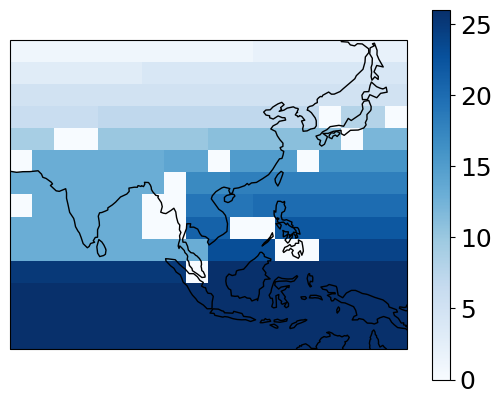

In [9]:
target = true_y
sample_num = len(target)
threshold = 0.5
cluster_num = 2
cluster = []

for i in range(14*18):
    cluster_grid = correlation_clustering(target, initial_index=i, threshold=threshold, sample_num=sample_num)
    cluster.append(cluster_grid)
    if i%50 == 0:
        print(f"initial index {i} is done")
reduced_cluster = reduce_cluster(cluster, cluster_num=cluster_num)
print(f"threshold: {threshold}, cluster_num: {cluster_num}, result: {len(reduced_cluster)}")
show_cluster(reduced_cluster)

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
threshold: 0.5, cluster_num: 2, result: 26


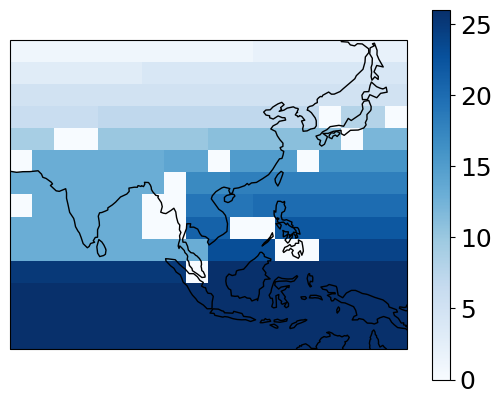

In [10]:
target = true_pred.T
sample_num = len(target)
threshold = 0.5
cluster_num = 2
cluster = []

for i in range(14*18):
    cluster_grid = correlation_clustering(target, initial_index=i, threshold=threshold, sample_num=sample_num)
    cluster.append(cluster_grid)
    if i%50 == 0:
        print(f"initial index {i} is done")
reduced_cluster = reduce_cluster(cluster, cluster_num=cluster_num)
print(f"threshold: {threshold}, cluster_num: {cluster_num}, result: {len(reduced_cluster)}")
show_cluster(reduced_cluster)